In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pandas as pd
import functools
from typing import Optional, Callable

## СКФ Гаусса

## Полином Лежандра

In [2]:
@functools.lru_cache(maxsize=None)
def legendre_polynom(
    arg: float,
    n: int
    ) -> float:
    
    if n == 0:
        return 1
    if n == 1:
        return arg
    
    return (2*n-1)/n * legendre_polynom(arg, n-1)*arg - (n-1)/n * legendre_polynom(arg, n-2)

In [3]:
def firstderiv_legendre_polynom(
    arg: float,
    n: int
    ) -> float:
    
    if n == 0:
        return 0
    if n == 1:
        return 1
    
    return n / (1 - arg*arg) * (legendre_polynom(arg, n - 1) - arg * legendre_polynom(arg, n))

In [4]:
def secondderiv_legendre_polynom(
    arg: float,
    n: int
    ) -> float:
    
    if n == 0 and n == 1:
        return 0
    
    return 2*n*arg/((1 -arg*arg)*(1-arg*arg)) \
         *(legendre_polynom(arg, n - 1) \
         -arg * legendre_polynom(arg, n)) \
         +n / (1 - arg*arg) * (firstderiv_legendre_polynom(arg, n-1) \
         -legendre_polynom(arg, n) - arg*firstderiv_legendre_polynom(arg, n))

In [5]:
def gauss_coefficient(
    nodes: np.ndarray,
    legendre_polynom: Optional[Callable],
    n: int
    ) -> np.ndarray:
    
    A = []
    
    for node in nodes:
        P = legendre_polynom(node, n-1)
        coef = 2*(1-node*node) / (n*n*P*P)
        A.append((node, coef))
    return np.array(A)

In [6]:
def separation_method(
    getFunc: Optional[Callable],
    N_nodes: int,
    left: float,
    right: float,
    N=1000
    ) -> np.ndarray:

    ans = []
    
    t = (right - left) / N
    x1 = left
    x2 = left + t 
    y1 = 0
    y2 = 0
    counter = 0
    while (x2 <= right):
        y1 = getFunc(x1, N_nodes)
        y2 = getFunc(x2, N_nodes)
        if (y1 * y2 <= 0):
            pair = (x1, x2)
            ans.append(pair)
            counter+=1
        x1 = x2
        x2 += t
    
    return ans

In [7]:
def secant_method(
    getFunc: Optional[Callable],
    N: int,
    lBound: float,
    rBound: float,
    epsilon: float
    ):
    if (getFunc(lBound, N) < epsilon):
        return lBound
    if (getFunc(rBound, N) < epsilon):
        return rBound
    
    prevSol = lBound + np.random.rand() * (rBound - lBound)
    while (secondderiv_legendre_polynom(prevSol, N) * getFunc(prevSol, N) <= 0):
         prevSol = lBound + np.random.rand() * (rBound - lBound)
    
    currSol = lBound + np.random.rand() * (rBound - lBound)
    nextSol = currSol - (getFunc(currSol, N) * (currSol - prevSol)
                         / (getFunc(currSol, N) - getFunc(prevSol, N)))
    
    step = 0
    while(np.abs(currSol - prevSol) >= epsilon):
        prevSol = currSol
        currSol = nextSol
        nextSol = currSol - (getFunc(currSol, N) * (currSol - prevSol)
                         / (getFunc(currSol, N) - getFunc(prevSol, N)))
        step += 1
    return currSol

In [8]:
def get_coefficient(
    N: int,
    left: float,
    right: float,
    epsilon=1e-12
    ) -> np.ndarray:
    segments = separation_method(legendre_polynom, N, left, right)
    nodes = []
    for l, r in segments:
        nodes.append(secant_method(legendre_polynom, N, l, r, epsilon))
    nodes = np.array(nodes)
    return gauss_coefficient(nodes, legendre_polynom, N)

In [9]:
def partition(left: float,
              right: float,
              m: int) -> np.array:
    h = (right - left) / m
    segments = [] 
    for n in range(m):
        segments.append((left + n*h, left + (n + 1)*h))
    return np.array(segments)

In [10]:
def compute_integral(
    nodes_cf: np.array,
    left: float,
    right: float,
    func: Callable,
    p: Callable
    ) -> float:
    integral = 0
    for node, cf in nodes_cf:
        arg = (left + right)/2 + (right - left)/2 * node
        integral += cf*p(arg)*func(arg)
    integral *= (right - left)/2
    return integral

In [11]:
def compoud(func: Callable,
            p: Callable,
            left: float,
            right: float,
            m: int,
            N: int) -> float:
    segments = partition(left, right, m)
    integral = 0
    nodes_cf = get_coefficient(N, -1, 1)
    for l, r in segments:
        int_lr = compute_integral(nodes_cf, l, r, func, p)
        integral += int_lr
    return integral

### Вариант 2

### $p(x) = x^{1/4}$

In [12]:
def p(arg: float) -> float:
    return np.sqrt(np.sqrt(arg))

### $f(x) = sin(x)$

In [13]:
def func(arg: float) -> float:
    return np.sin(arg)

### $\int\limits_0^1 x^{1/4}sin(x)dx = 0.406538308297265$

In [14]:
I = 0.406_538_308_297_265

In [15]:
N = int(input())
m = int(input())
left, right = map(int, input().split())

8 
10000
0 1


In [16]:
value = compoud(func, p, left, right, m, N)
error = np.abs(value - I)
print(f"value = {value}")
print(f"true value = {I}")
print(f"error = {error}")

value = 0.40707700338390546
true value = 0.406538308297265
error = 0.0005386950866404505


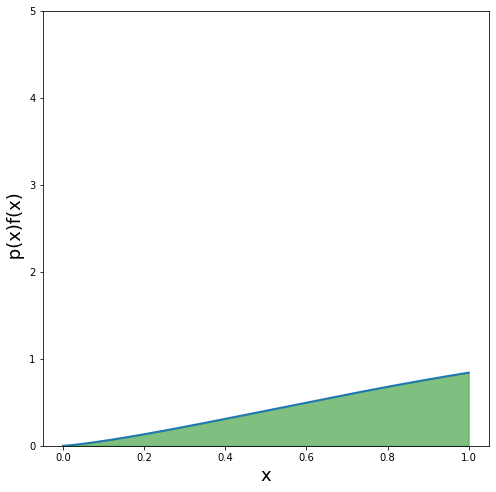

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
x = np.linspace(left, right, 10000)
ax.plot(x, p(x)*func(x), lw=2)
ax.fill_between(x, p(x)*func(x), color='green', alpha=0.5)
ax.set_xlabel("x", fontsize=18)
ax.set_ylabel(" p(x)f(x)", fontsize=18)
ax.set_ylim(0, 5)
plt.show()

In [18]:
N = np.array([2, 4, 5, 6, 7, 8, 9, 10])
m = np.array([5, 10, 100, 1000, 10000])
array_values = []
array_errors = []
for N_ in N:
    array = []
    array1 = []
    for m_ in m:
        value = compoud(func, p, left, right, m_, N_)
        error = np.abs(value - I)
        array.append(value)
        array1.append(error)
    array_values.append(array)
    array_errors.append(array1)

In [19]:
df1 = pd.DataFrame(np.array(array_values),
                  columns=m,
                  index=N)
df1.name = "Values"

In [20]:
df2 = pd.DataFrame(np.array(array_errors),
                  columns=m,
                  index=N)
df2.name = "Errors"

In [21]:
print(df1.name)
df1

Values


,5,10,100,1000,10000
2,0.409365,0.409393,0.409401,0.409401,0.409401
4,0.412002,0.411999,0.411997,0.411997,0.411997
5,0.401978,0.401576,0.401212,0.401176,0.401172
6,0.408448,0.408444,0.408442,0.408442,0.408442
7,0.412206,0.411580,0.411019,0.410963,0.410957
8,0.407078,0.407077,0.407077,0.407077,0.407077
9,0.398217,0.397702,0.397232,0.397185,0.397180
10,0.447582,0.447510,0.447480,0.447479,0.447479


In [22]:
print(df2.name)
df2

Errors


,5,10,100,1000,10000
2,0.002827,0.002855,0.002862,0.002862,0.002862
4,0.005464,0.005460,0.005459,0.005459,0.005459
5,0.004561,0.004962,0.005326,0.005363,0.005366
6,0.001910,0.001906,0.001904,0.001904,0.001904
7,0.005667,0.005042,0.004481,0.004425,0.004419
8,0.000540,0.000539,0.000539,0.000539,0.000539
9,0.008321,0.008836,0.009306,0.009354,0.009358
10,0.041043,0.040972,0.040942,0.040941,0.040941


<AxesSubplot:title={'center':'Error by N'}, xlabel='N', ylabel='Error'>

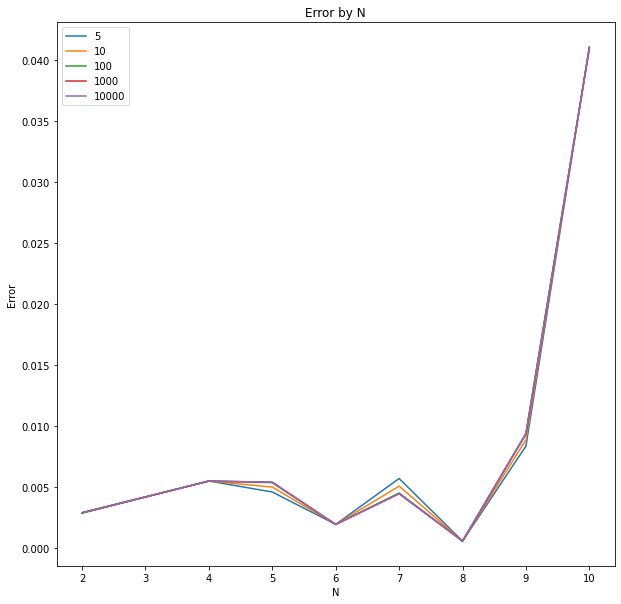

In [23]:
df2.plot(title="Error by N", xlabel="N", ylabel="Error", figsize=(10,10))

In [24]:
minindex = np.argmin(np.array(df2[5:6]))
m[minindex]

10000

## КФНАСТ

### $p(x) = x^{1/4}$

### $f(x) = sin(x)$

In [25]:
N1 = int(input())

8


### Найдем моменты

In [26]:
def moment(p: Callable,
           k: int,
           left: float,
           right: float) -> float:
    s = 1/4 + k
    I = lambda x: x**(s+1)/(s+1)
    return I(right) - I(left)

In [27]:
mu = []
for k in range(2*N1):
    mu.append(moment(p, k, left, right))

In [28]:
mu

[0.8,
 0.4444444444444444,
 0.3076923076923077,
 0.23529411764705882,
 0.19047619047619047,
 0.16,
 0.13793103448275862,
 0.12121212121212122,
 0.10810810810810811,
 0.0975609756097561,
 0.08888888888888889,
 0.08163265306122448,
 0.07547169811320754,
 0.07017543859649122,
 0.06557377049180328,
 0.06153846153846154]

In [29]:
from scipy.linalg import solve

In [30]:
A = []
for n in range(N1-1, 2*N1 - 1):
    a = mu[n - N1 + 1:n + 1]
    a.reverse()
    A.append(a)

In [31]:
A = np.array(A)

### Решаем алгебраическое уравнение вида Ax=b

### где $A \in R^{N\times N}$ и $b \in R^{N}$

In [32]:
A

array([[0.12121212, 0.13793103, 0.16      , 0.19047619, 0.23529412,
        0.30769231, 0.44444444, 0.8       ],
       [0.10810811, 0.12121212, 0.13793103, 0.16      , 0.19047619,
        0.23529412, 0.30769231, 0.44444444],
       [0.09756098, 0.10810811, 0.12121212, 0.13793103, 0.16      ,
        0.19047619, 0.23529412, 0.30769231],
       [0.08888889, 0.09756098, 0.10810811, 0.12121212, 0.13793103,
        0.16      , 0.19047619, 0.23529412],
       [0.08163265, 0.08888889, 0.09756098, 0.10810811, 0.12121212,
        0.13793103, 0.16      , 0.19047619],
       [0.0754717 , 0.08163265, 0.08888889, 0.09756098, 0.10810811,
        0.12121212, 0.13793103, 0.16      ],
       [0.07017544, 0.0754717 , 0.08163265, 0.08888889, 0.09756098,
        0.10810811, 0.12121212, 0.13793103],
       [0.06557377, 0.07017544, 0.0754717 , 0.08163265, 0.08888889,
        0.09756098, 0.10810811, 0.12121212]])

In [33]:
b = []
for i in range(N1, 2*N1):
    b.append(-mu[i])

In [34]:
b = np.array(b)

In [35]:
b = b.reshape((N1,1))

In [36]:
b

array([[-0.10810811],
       [-0.09756098],
       [-0.08888889],
       [-0.08163265],
       [-0.0754717 ],
       [-0.07017544],
       [-0.06557377],
       [-0.06153846]])

### Решаем уравнение

In [37]:
a = solve(A, b)

### И получаем

In [38]:
a

array([[-4.06153840e+00],
       [ 6.75813346e+00],
       [-5.92818713e+00],
       [ 2.93613035e+00],
       [-8.14925952e-01],
       [ 1.17711522e-01],
       [-7.38260388e-03],
       [ 1.24706140e-04]])

### Транспонируем

In [39]:
a = a.reshape((1, N1))

In [40]:
a

array([[-4.06153840e+00,  6.75813346e+00, -5.92818713e+00,
         2.93613035e+00, -8.14925952e-01,  1.17711522e-01,
        -7.38260388e-03,  1.24706140e-04]])

### Найдем корни многочлена вида $x^N + a_1x^{N-1} + ... + a_{N-1}$

In [41]:
a = np.append([1], a)

In [42]:
x = np.roots(a)

### И получили корни

In [43]:
x

array([0.98070789, 0.90113422, 0.76895363, 0.60147534, 0.42066988,
       0.2502593 , 0.11260051, 0.02573764])

In [44]:
def polynom(arg: float, coefs: np.array, N: int) -> float:
    pol = 0
    for (st, coef) in enumerate(coefs):
        pol += coef * arg**(N-st)
    return pol

### Посмотрим на максимальную погрешность корня

In [45]:
max_error = np.abs(polynom(x[0], a, N1))
for i in x:
    max_error = max(max_error, np.abs(polynom(i, a, N1)))

In [46]:
max_error

2.5495014085996637e-16

### Найдем коэффициенты, решив алгебраическое уравнение вида $Ax=b$

### Составим матрицу A

In [47]:
A1 = []
for s in range(N1):
    A1.append(x**s)
A1 = np.array(A1)

In [48]:
A1

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.80707886e-01, 9.01134225e-01, 7.68953627e-01, 6.01475343e-01,
        4.20669880e-01, 2.50259296e-01, 1.12600506e-01, 2.57376403e-02],
       [9.61787958e-01, 8.12042891e-01, 5.91289680e-01, 3.61772588e-01,
        1.76963148e-01, 6.26297155e-02, 1.26788739e-02, 6.62426130e-04],
       [9.43233035e-01, 7.31759641e-01, 4.54674344e-01, 2.17597292e-01,
        7.44430665e-02, 1.56736685e-02, 1.42764761e-03, 1.70492855e-05],
       [9.25036076e-01, 6.59413656e-01, 3.49623486e-01, 1.30879406e-01,
        3.13159559e-02, 3.92248126e-03, 1.60753843e-04, 4.38808377e-07],
       [9.07190174e-01, 5.94220214e-01, 2.68844247e-01, 7.87207355e-02,
        1.31736794e-02, 9.81637400e-04, 1.81009640e-05, 1.12938922e-08],
       [8.89688558e-01, 5.35472172e-01, 2.06728759e-01, 4.73485814e-02,
        5.54177014e-03, 2.45663885e-04, 2.03817770e-06, 2.

In [49]:
b1 = []
for i in range(N1):
    b1.append(mu[i])
b1 = np.array(b1)

In [50]:
b1

array([0.8       , 0.44444444, 0.30769231, 0.23529412, 0.19047619,
       0.16      , 0.13793103, 0.12121212])

In [51]:
a1 = solve(A1, b1)

In [52]:
coef = a1

In [53]:
coef

array([0.04894973, 0.10546136, 0.1434545 , 0.15680241, 0.14460223,
       0.11139347, 0.06648656, 0.02284973])

### Сделаем проверку на многочлене $f(x) = x^{N + 1}$

In [54]:
def checkf(arg: float) -> float:
    global N1
    return arg**(2 * N1 - 1)

In [55]:
def cfnast(func: Callable,
           a: np.array,
           x: np.array,
           N: int
           ) -> float:
    res = 0
    for k in range(N):
        res += a[k]*func(x[k])
    return res

In [56]:
print(f"value = {cfnast(checkf, coef, x, N1)}")
print(f"mu_2N-1 = {mu[2*N1-1]}")
print(f"Error = {np.abs(mu[2*N1-1] - cfnast(checkf, coef, x, N1))}")

value = 0.06153846153849282
mu_2N-1 = 0.06153846153846154
Error = 3.1280533718813786e-14


### Теперь посчитаем для функции из варианта

In [57]:
print(f"value = {cfnast(func, coef, x, N1)}")
print(f"true_value = {I}")
print(f"Error = {np.abs(I - cfnast(func, coef, x, N1))}")

value = 0.40653830829726545
true_value = 0.406538308297265
Error = 4.440892098500626e-16
